In [61]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [62]:
import numpy as np
import tensorflow.keras as keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In this project I have used a pre-trained [YOLOv3](https://arxiv.org/abs/1804.02767) model for object detection. The "yolo_helper_functions" Python file includes the implementation of the YOLO v3 algorithm. The pre-trained weights are downloaded from [YOLO website](https://pjreddie.com/darknet/yolo/). These weights are based on training the model on the MSCOCO data set.

The keras implementation of the model was taken from [experiencor](https://github.com/experiencor/keras-yolo3)'s github repository.

Most of the components that decode the bounding boxes from the outputs of the model, are based on the experiencor's implementation. I modified some of them to achieve better performance.



In [63]:
# Import the yolo_helper_functions.py file
exec(open("/content/gdrive/My Drive/YOLO/yolo_helper_functions.py").read())

In [64]:
# Make the YOLO model
model=make_yolov3_model()

In [65]:
# Load the weights into memory in a format that is readable by keras
weightreader=WeightReader('/content/gdrive/My Drive/YOLO/yolov3.weights')# create an object of the Weightreader class

In [66]:
# Set the weights to the layers of the model
weightreader.load_weights(model)

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [67]:
model.save('/content/gdrive/My Drive/YOLO/keras_model/model.h5')

For the purpose of object detection using the above pretrained model, the size of the image should be converted to (416,416) to be compatible with the model.

In [68]:
#Load the image with the desired size
image=load_img('/content/gdrive/My Drive/YOLO/images/street.jpg',target_size=(416,416))

We need the size of the original image before the preprocessing step. It will be used when we want to scale back the bounding boxes to the original shape of the image.

In [69]:
original_image=load_img('/content/gdrive/My Drive/YOLO/images/street.jpg')
width, height=original_image.size
print("width:",width)
print("height:",height)

width: 3652
height: 1240


In the image preprocessing steps the PIL image is converted to a numpy array. Then the pixel values are divided by 255 (The maximum value in the color scale). As a result, all the pixel values will be in range [0,1].

In [70]:
# IMAGE PREPROCESSING
# Convert the PIL Image instance to a Numpy array
image=img_to_array(image)
# Scale the pixel values to [0,1]
image=image.astype('float32')
image/=255.0
# Expand the dimensions of the image, the dimension of the image will be (1,416,416,3)
image=np.expand_dims(image,0)

In this step, the image is passed to the  YOLO model. The model considers three grid sizes: 13 x 13, 26 x 26 and 52 x 52. For each grid cell it returns three bounding boxes. Each bounding box is represented by a 85 dimensional vector(tx,ty,tw,th,Pc,C1,C2,...,C80)). tx,ty are related to the center coordinate of the bounding box and tw,th are related to the width and height of the bounding box. Pc will be used to determine the probability that the bounding box includes an object. C1,...,C80 are used to compute the probability that the bounding box has the object from class Ci. 
As a result, for each grid cell there are 3 x 85 dimensional vectors which could be rolled to a single 255 vector.

In [71]:
# Make predictions
yhat=model.predict(image)
print([i.shape for i in yhat])

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [72]:
# based on https://github.com/experiencor/keras-yolo3
from matplotlib import pyplot
from matplotlib.patches import Rectangle

Feeding the image to the YOLO model will return all the candidate bounding boxes. We should choose the best ones after some processing. The functions that we are going to use for this purpose, are included in the functions.py file: 

In [73]:
exec(open("/content/gdrive/My Drive/YOLO/functions.py").read())

 

- As it was metioned earlier, the input size of the image must be 416 x416.

- For each grid size, 3 anchor boxes(determined by width and height) are provided which will be used as a base to acquire the final bounding boxes. The width and height of the anchor boxes(pw,ph) have been selected by considering the size of various objects in MSCOCO data set and the use of clustering algorithms(for further information refer to the YOLO paper). 

- In the code cell below, "anchors" is a list of length 3. Each of the elements corresponds to the dimensions of anchor boxes given different grid sizes. For example, [116,90, 156,198, 373,326] includes the heights and widths of 3 anchor boxes for 13x13 grid size.



- In the following script, the decode_netout function is called which returns 10647 bounding boxes after passing the image to the model. Following you can find how 10647 is acquired:

    (13x13x3)+(26x26x3)+(52x52x3)= 10647

- The inputs fed to the decode_netout funtion:

    yhat[i][0]: bounding boxes for grid size i => shape=(grid size, grid size,3)
    
    anchors[i]: the  three anchors defined for that grid size[width1,height1, width2, height2, width3, height]
    
    threshold 
    
    the network's input size (416x416)
#decode_netout function:
- computes the objectness score and class score:

    objectness=sigmoid(Pc)

    class score= sigmoid(Pc).sigmoid(Ci) , for each class i 
- sets the class score to 0 if the class score of that class is smaller than the threshold(0.5)
- keeps the bounding boxes with objectness greater than a threshold
- decodes the coordinates of the remaining boxes (xmin,ymin,xmax,yman) with respect to the unit image

    


In [74]:
input_w, input_h = 416, 416
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.5
boxes = list()
                        
for i in range(len(yhat)):                                                      
  # decode the output of the network
  boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

# correct_yolo_boxes funtion:
- As the coordinates of the bounding boxes that we get from decode_netout() function are with respect to the unit image, they should be converted to the real coordinates based on the size of the original image.
- In the following funtion:

    - boxes is list of BoundingBox objects.

    -  height and width demonstrate the size of the origitnal image.

    - input_h, input_w= 416,416 (inputs to the network)
    




In [75]:
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, height, width, input_h, input_w)

# Non maximum suppression:

This function gets all the candidate bounding boxes and gets rid of the ones that detect the same object multiple times in the image. The functionality of non max suppression can be broken into 7 steps:




1.   iterates over the classes(in this case=80)
2.   for each class sorts all the candidate bounding boxes from the most probable to the least probable (based on the class score)=> so we have an array in which we have the indices of the sorted bounding boxes. 
3. choose the most probable bounding box 
4. if the class score of the bounding box for class c is not 0, proceed with the next steps
5. iterate over all the other bounding boxes with class score less than our candidate=> # iteration= #bounding boxes-1 
6. Compute the IoU between the most probable bounding box and all the other bounding boxes, if it is greater than the threshold=> set the class score for the second bounding box to zero(Ci=0)

    **ATTENTION**: We **do not remove** the second bouning box from the list, as each bounding box is free to detect objects from different classes. If we remove it, there is no chance to use it for detecting other objects.
7. go to the next most probable bounding box and iterate over all of the bounding boxes with a lower score and repeat the previous steps.




In [76]:
# suppress non-maximal boxes
do_nms(boxes, 0.5)

# get_boxes function:
1.For each bounding box, this function iterates over all of the classes and 
compares the class scores of that bounding box. Then it assigns the class number which has the maximum class score, to the bounding box. The point is that the class score should be greater than a threshold.

2.Then it iterates over the bounding boxes again and computes the IoU for each pair of them. If it is greater than a large threshold (e.g 0.8) , removes the one with smaller class score(note that these two bounding boxes have different labels). This prevents having two bounding boxes predicting two labels for the same object.

**Note**: labels list shows all the classes that YOLO V3 trained on MSCOCO dataset can detect in images.

In [77]:
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
  "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
  "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
  "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
  "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
  "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
  "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
  "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
  "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
  "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)


#draw_boxes function:

This function displays the original image with the bounding boxes around the detected objects. It draws a rectangle around the objects using the given the width and height of each box and the coordinates of the top left corner of the box.

truck 57.16499090194702
car 85.92456579208374
car 95.71095705032349
car 82.01164603233337
truck 84.82975959777832
car 92.95653104782104
person 97.54208326339722
person 54.63883876800537
person 91.47090315818787
car 92.72606372833252
car 98.59970808029175
car 94.3382203578949
car 81.11327290534973
car 60.287123918533325
person 54.2446494102478


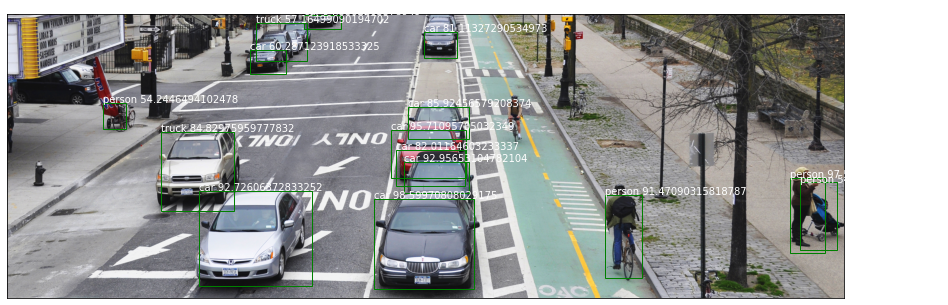

In [78]:
# summarize what we found
for i in range(len(v_boxes)):
  print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes('/content/gdrive/My Drive/YOLO/images/street.jpg', v_boxes, v_labels, v_scores)


#Testing it on a few images:

In [79]:
images=['/content/gdrive/My Drive/YOLO/images/basket.jpg',
        '/content/gdrive/My Drive/YOLO/images/kitchen.jpg',
        '/content/gdrive/My Drive/YOLO/images/kite.jpg',
        '/content/gdrive/My Drive/YOLO/images/living room.jpg',
        '/content/gdrive/My Drive/YOLO/images/office.jpg',
        '/content/gdrive/My Drive/YOLO/images/street2.jpg'
        ]
for j in range (len(images)):
  #Load the image with the desired size
  image=load_img(images[j],target_size=(416,416))
  original_image=load_img(images[j])
  width, height=original_image.size
  # IMAGE PREPROCESSING
  # Convert the PIL Image instance to a Numpy array
  image=img_to_array(image)
  # Scale the pixel values to [0,1]
  image=image.astype('float32')
  image/=255.0
  # Expand the dimensions of the image, the dimension of the image will be (1,416,416,3)
  image=np.expand_dims(image,0)
  # Make predictions
  yhat=model.predict(image) 
  boxes = list()
                        
  for i in range(len(yhat)):                                                      
  # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
  # correct the sizes of the bounding boxes for the shape of the image  
  correct_yolo_boxes(boxes, height, width, input_h, input_w)
  # suppress non-maximal boxes
  do_nms(boxes, 0.5)
  # get the details of the detected objects
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
  for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
  # draw what we found
  draw_boxes(images[j], v_boxes, v_labels, v_scores)

  


        

Output hidden; open in https://colab.research.google.com to view.